In [1]:
# General Dependencies
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils.noise import estimate_noise

# CPP Wrapper Dependencies
from trefide.pmd import patch_pmd

# Experimental Implementation Dependencies
from trefide.temporal import TrendFilter
from trefide.utils.greedyPCA import choose_rank
from prox_tv import tv1_2d

# Plotting & Video Dependencies
import matplotlib.pyplot as plt
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imshow

%load_ext autoreload
%autoreload 2

# functions to migrate

In [2]:
def eval_tv(image):
    return np.sum(np.abs(image[1:,:] - image[:-1,:])) + np.sum(np.abs(image[:,1:] - image[:,:-1]))

In [3]:
def play(movie, gain=3, fr=120, offset=0, magnification=3):
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(350, 1000):
            if magnification != 1:
                frame = cv2.resize(movie[:,:,t],
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

# Decompose In Parallel

In [4]:
X = np.load("../data/prepared_sampleMovie.npy")
d1, d2, T = X.shape

In [5]:
from trefide.pmd import blockwise_pmd

In [6]:
from trefide.pmd import parallel_pmd

In [7]:
max_components = 20
maxiter=50
tol = 5e-3
bheight = 40
bwidth = 200
spatial_cutoff = (bheight*bwidth / ((bheight*(bwidth-1) + bwidth*(bheight-1)))) #.1#.0085#
w=.0025

In [8]:
U, V, K, indices = blockwise_pmd(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

In [ ]:
U, V, K, indices = parallel_pmd(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

In [9]:
K

array([ 7, 11, 17, 17,  9, 12, 11, 11], dtype=uint64)

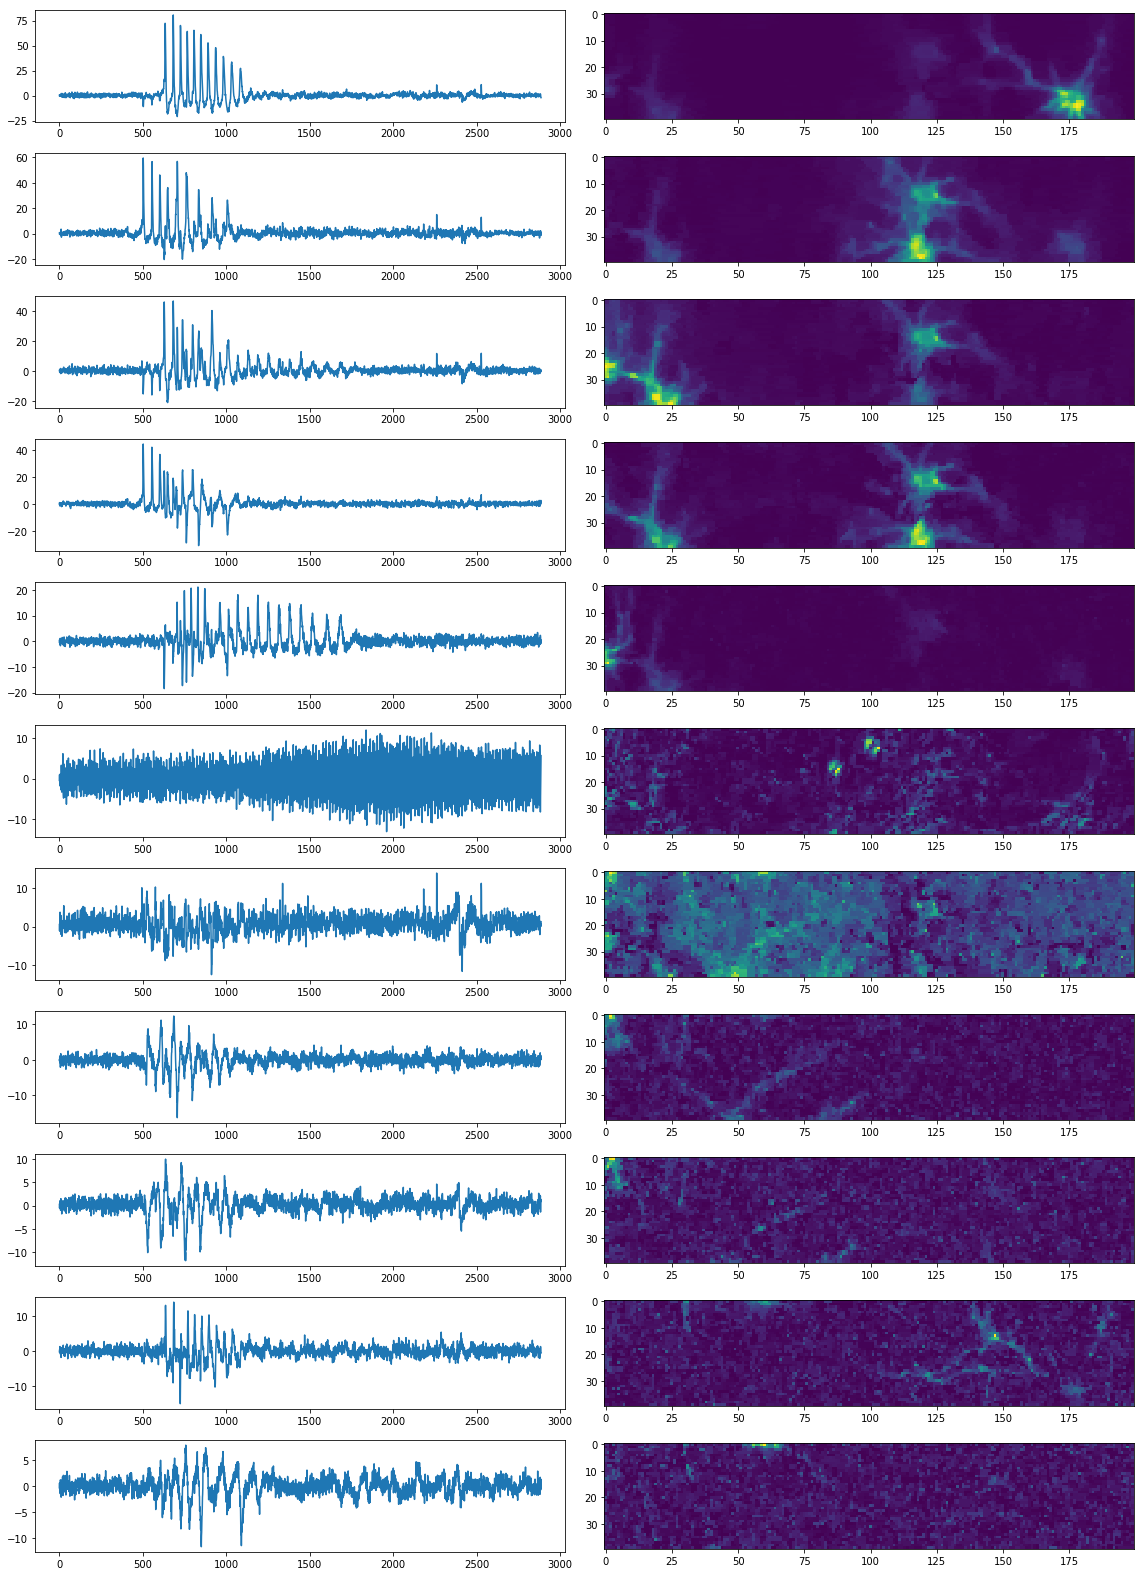

In [10]:
b_idx = -1
fig, ax = plt.subplots(int(K[b_idx]), 2, figsize=(16, 2*int(K[b_idx])))
for k in range(int(K[b_idx])):
    ax[k,0].plot(np.arange(T), V[b_idx, k, :])
    ax[k,1].imshow(np.abs(U[b_idx,:,:,k]))
    #ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    #ax[k,1].set_title("Spatial component {}, Passed: {}".format(k,k < K_prev[b_idx]))
plt.tight_layout()
plt.show()

In [238]:
#tmp_real_tv = normalized_tv
#tmp_real_l1 = normalized_l1
#tmp_keep = keep
normalized_tv = np.empty(np.sum(K))
normalized_l1 = np.empty(np.sum(K))
keep = np.zeros(np.sum(K), dtype=bool)
idx = 0
for b_idx, components in enumerate(K):
    for k in range(components):
        normalized_tv[idx] = eval_tv(U[b_idx,:,:,k]) / (bheight*(bwidth-1) + bwidth*(bheight-1))
        normalized_l1[idx] = np.sum(np.abs(U[b_idx,:,:,k])) / (bheight*bwidth)
        if k < K_prev[b_idx]:
            keep[idx] = True
        idx += 1

In [131]:
#tmp_tv = noise_normalized_tv
#tmp_l1 = noise_normalized_l1
noise_normalized_tv = np.empty(np.sum(K))
noise_normalized_l1 = np.empty(np.sum(K))
idx = 0
for b_idx, components in enumerate(K):
    for k in range(components):
        noise_normalized_tv[idx] = eval_tv(U[b_idx,:,:,k]) / (bheight*(bwidth-1) + bwidth*(bheight-1))
        noise_normalized_l1[idx] = np.sum(np.abs(U[b_idx,:,:,k])) / (bheight*bwidth)
        idx += 1

In [239]:
#thresh = .0086
#thresh = .0186
#np.argwhere(np.logical_and(normalized_tv  < thresh, ~keep))
#np.argwhere(np.logical_and(normalized_l1/normalized_tv >1, ~keep))

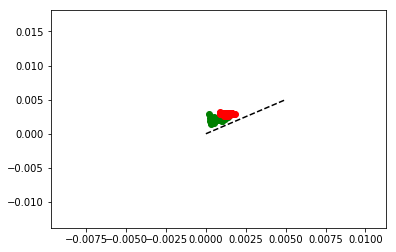

In [242]:
#rescale = (bheight*(bwidth-1) + bwidth*(bheight-1))/ (2*bwidth*bheight)
rescale = 1
plt.scatter(normalized_tv[keep]*rescale, normalized_l1[keep]*rescale, color='g')
plt.scatter(normalized_tv[~keep]*rescale, normalized_l1[~keep]*rescale, color='r')
#plt.scatter(noise_normalized_tv*rescale, noise_normalized_l1*rescale, color ='b')
#plt.plot([thresh, thresh], [0, 1], "m--")
plt.plot([0,.005],[0,.005], 'k--')
#plt.xlim([0,.06])
#plt.ylim([0,.06])
#plt.xlim([0,.025])
#plt.ylim([0,.03])
#plt.xlim([0,.015])
#plt.ylim([0,.014])
plt.show()

In [162]:
np.savez("../data/test_blocks_" + str(bheight) + "_" + str(bwidth),
            noise_normalized_tv=noise_normalized_tv,
            noise_normalized_l1=noise_normalized_l1,
            normalized_tv=normalized_tv,
            normalized_l1=normalized_l1,
            keep=keep, d1=bheight, d2=bwidth)

In [39]:
np.min(noise_normalized_tv[noise_idx])

0.008688155376448247

In [27]:
noise_idx = ~np.isnan(noise_normalized_tv)

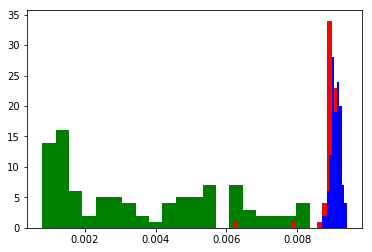

In [36]:
plt.hist(normalized_tv[keep], bins=20, color='g')
plt.hist(normalized_tv[~keep], bins=20, color='r')
plt.hist(noise_normalized_tv[noise_idx], color='b')
plt.show()

In [235]:
b_idx
denoised = U[b_idx,:,:,:K[b_idx]].dot(V[b_idx, :K[b_idx],:]).reshape((bheight,bwidth,T), order='F')
idx, jdx = indices[b_idx]
idx *= bheight
jdx *= bwidth
raw = X[idx:idx+bheight, jdx:jdx+bwidth]
residual = raw - denoised
play(np.vstack([raw, denoised, residual]), magnification=7)

In [11]:
reconstructed = np.zeros(np.prod(X.shape)).reshape(X.shape)
for b_idx, num_components in enumerate(K):
    for k in range(num_components):
        idx, jdx = indices[b_idx]
        idx *= bheight
        jdx *= bwidth
        reconstructed[idx:idx+bheight, jdx:jdx+bwidth] += U[b_idx,:,:,k][:,:,None].dot(V[b_idx,k,:][None,:]).reshape((bheight,bwidth,T), order='F')

In [12]:
play(np.vstack([X, reconstructed, X - reconstructed]), magnification=2)

In [213]:
play(np.vstack([reconstructed]), magnification=2)

In [196]:
reconstructed[np.isnan(reconstructed)] = 0

In [211]:
len(K)

32

In [210]:
len(indices)

32

# Run Iterations and Collect Data

In [1]:
K = 20
U = np.zeros((d1*d2, K), dtype=np.float64, order='F')
V = np.zeros((K,T), dtype=np.float64, order='C')
maxiter=50
n_metrics=3
tol = 5e-3
spatial_cutoff = (d1*d2 / ((d1*(d2-1) + d2*(d1-1))))*1.05
w=.0025
R = X.copy(order='F').reshape((d1*d2,T), order='F').reshape((d1*d2*T), order='F')

NameError: name 'np' is not defined

In [19]:
K = call_pmd(d1, d2, T, R, U.reshape((d1*d2*K), order='F'), V.reshape(T*K, order='C'), w, spatial_cutoff, K, maxiter, tol)

In [20]:
thresh= (d1*d2 / ((d1*(d2-1) + d2*(d1-1))))*1.05
metric = np.empty(K)
for k in range(K):
    metric[k] = np.sum(np.abs(U[:,k])) / eval_tv(U[:,k].reshape(Y_block.shape[:2], order='F')) 
temporal_failed = np.argwhere(np.isnan(choose_rank(V, maxlag=10, confidence=.99, mean_th_factor=2)[0,:])).flatten()
keep = np.setdiff1d(np.argwhere(metric > thresh), temporal_failed)
print("components to keep:" + str(keep))

components to keep:[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14]


/home/ian/devel/trefide/trefide/utils/greedyPCA.py:250: RuntimeWarning: invalid value encountered in true_divide
  vi =(vi - vi.mean())/vi.std()


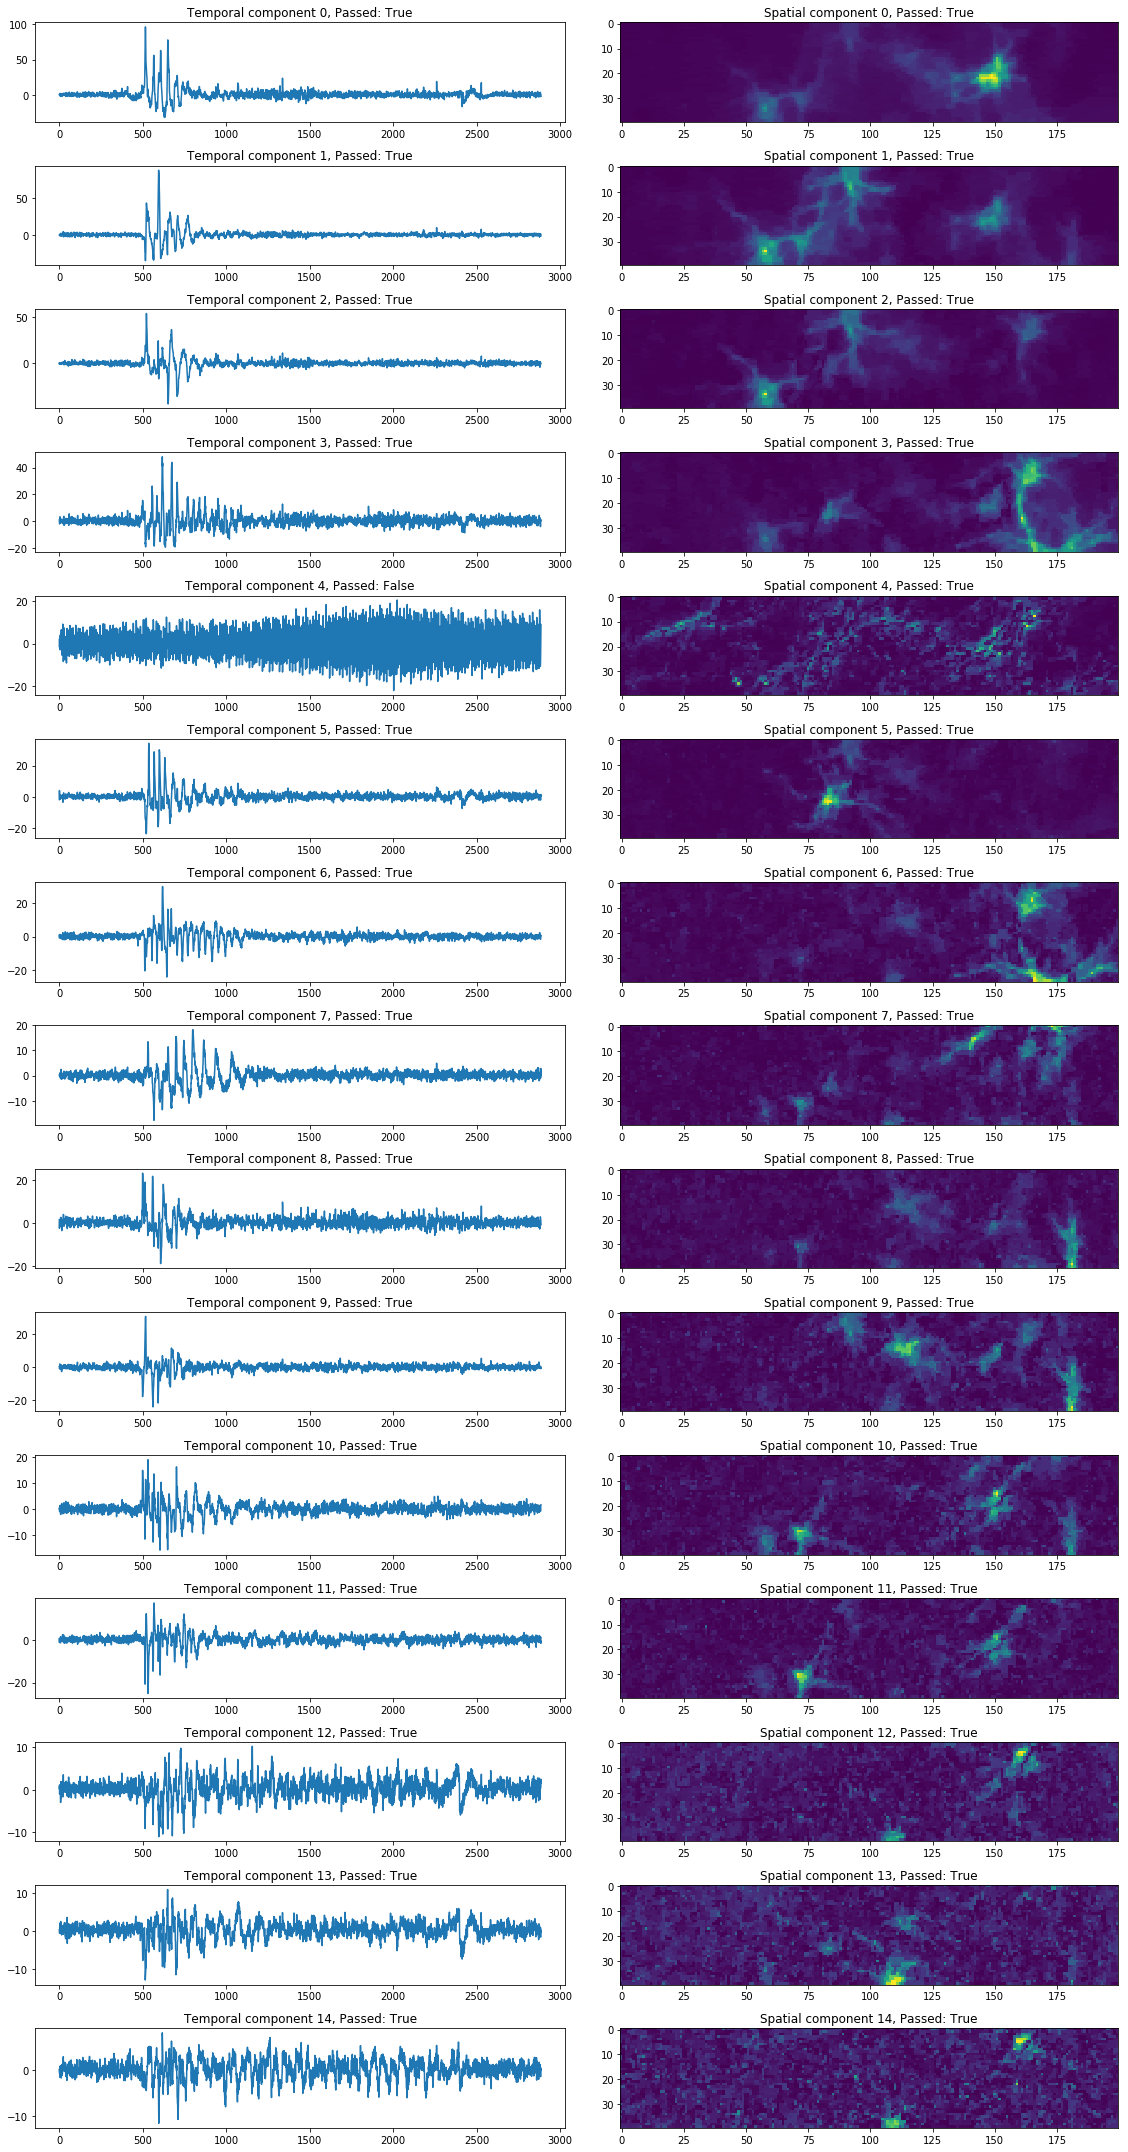

In [21]:
fig, ax = plt.subplots(K, 2, figsize=(16,2*K))
for k in range(K):
    ax[k,0].plot(np.arange(V.shape[-1]), V[k,:])
    ax[k,1].imshow(np.abs(U[:,k].reshape(Y_block.shape[:2], order='F')))
    ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    ax[k,1].set_title("Spatial component {}, Passed: {}".format(k, k in np.argwhere(metric > thresh)))
plt.tight_layout()
plt.show()

### Debias Spatial And View Movie

In [22]:
Y_block = Y_block.reshape((d1*d2, T), order='F')
V_final = np.linalg.inv(U[:,keep].T.dot(U[:,keep])).dot(U[:,keep].T.dot(Y_block))
U_final = Y_block.dot(V_final.T.dot(np.linalg.inv(V_final.dot(V_final.T))))
denoised = U_final.dot(V_final).reshape((d1,d2,T), order='F')
raw = Y_block.reshape((d1, d2, T), order='F')
residual = raw - denoised
play(np.vstack([raw, denoised, np.abs(raw-denoised)]), magnification=7)

In [24]:
#X = Y_block.reshape((np.prod(Y_block.shape[:2]), Y_block.shape[-1]), order='F')
#V_final = np.linalg.inv(U[:,keep].T.dot(U[:,keep])).dot(U[:,keep].T.dot(X))
#U_final = X.dot(V_final.T.dot(np.linalg.inv(V_final.dot(V_final.T))))
denoised = U[:,keep].dot(V[keep,:]).reshape((d1,d2,T), order='F')
raw = X
residual = raw - denoised
play(np.vstack([raw, denoised, np.abs(raw-denoised)]), magnification=7)

# Experimental Implementation (For Testing New Features)

In [27]:
X = X.reshape((np.prod(Y_block.shape[:2]), Y_block.shape[-1]))

In [12]:
K = 20
maxiter=50
n_metrics=3
tol = 5e-3
spatial_cutoff = (d1*d2 / ((d1*(d2-1) + d2*(d1-1))))*1.05
w=.0025
U = np.zeros((K, X.shape[0]))
S = np.zeros(K)
V = np.zeros((K, X.shape[1]))
progress = np.zeros((K, maxiter, n_metrics))

In [13]:
for k in range(K):
    u = np.ones(U.shape[-1])
    #u = np.random.randn(U.shape[-1])
    u = u / np.linalg.norm(u)
    trend_filter = TrendFilter(V.shape[-1], verbose=1)
    v = X.T.dot(u)
    v = trend_filter.denoise(v)
    #v = trend_filter.denoise(v, delta=min(1, np.mean(np.power(v,2))-.0001))
    #v = np.dot(X.T, u)
    v = v / np.linalg.norm(v)
    v_prev = v
    u_prev = u
    for iter_ in range(maxiter):
        u = np.dot(X, v)
        u = u / np.linalg.norm(u)
        u =tv1_2d(u.reshape(Y_block.shape[:2]), w=w, max_iters=1).reshape((len(u),))
        u = u / np.linalg.norm(u)
        #v = np.dot(X.T, u)
        #v = v / np.linalg.norm(v) 
        v = X.T.dot(u)
        v = trend_filter.denoise(v)
        #v = trend_filter.denoise(v, delta=min(1, np.mean(np.power(v,2))-.0001))
        v = v / np.linalg.norm(v)
        progress[k, iter_, 0] = u.T.dot(X).dot(v)
        progress[k, iter_, 1] = np.linalg.norm(v - v_prev)
        progress[k, iter_, 2] = np.linalg.norm(u - u_prev)
        v_prev = v
        u_prev = u
        if iter_ > 5:
            rel_diff = np.abs(progress[k,iter_-1,0] - progress[k,iter_,0]) / progress[k,iter_-1,0]
            if np.max([rel_diff,  progress[k, iter_, 1],  progress[k, iter_, 2]]) < tol:
                break
        if iter_ == 9:
            if np.sum(np.abs(u)) / eval_tv(u.reshape(Y_block.shape[:2])) < spatial_cutoff:
                break
            
    if np.sum(np.abs(u)) / eval_tv(u.reshape(Y_block.shape[:2])) < spatial_cutoff:
        break
    else:
        U[k,:] = u
        #V[k,:] = v
        V[k,:] = X.T.dot(u)
        V[k,:] /= np.linalg.norm(V[k,:])
        S[k] = np.dot(np.dot(X,V[k,:]).T, U[k,:])
        X -= S[k] * U[k,:][:,None].dot(V[k,:][None,:])
        print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [14]:
K = k

/home/ian/miniconda3/envs/idp3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ian/miniconda3/envs/idp3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


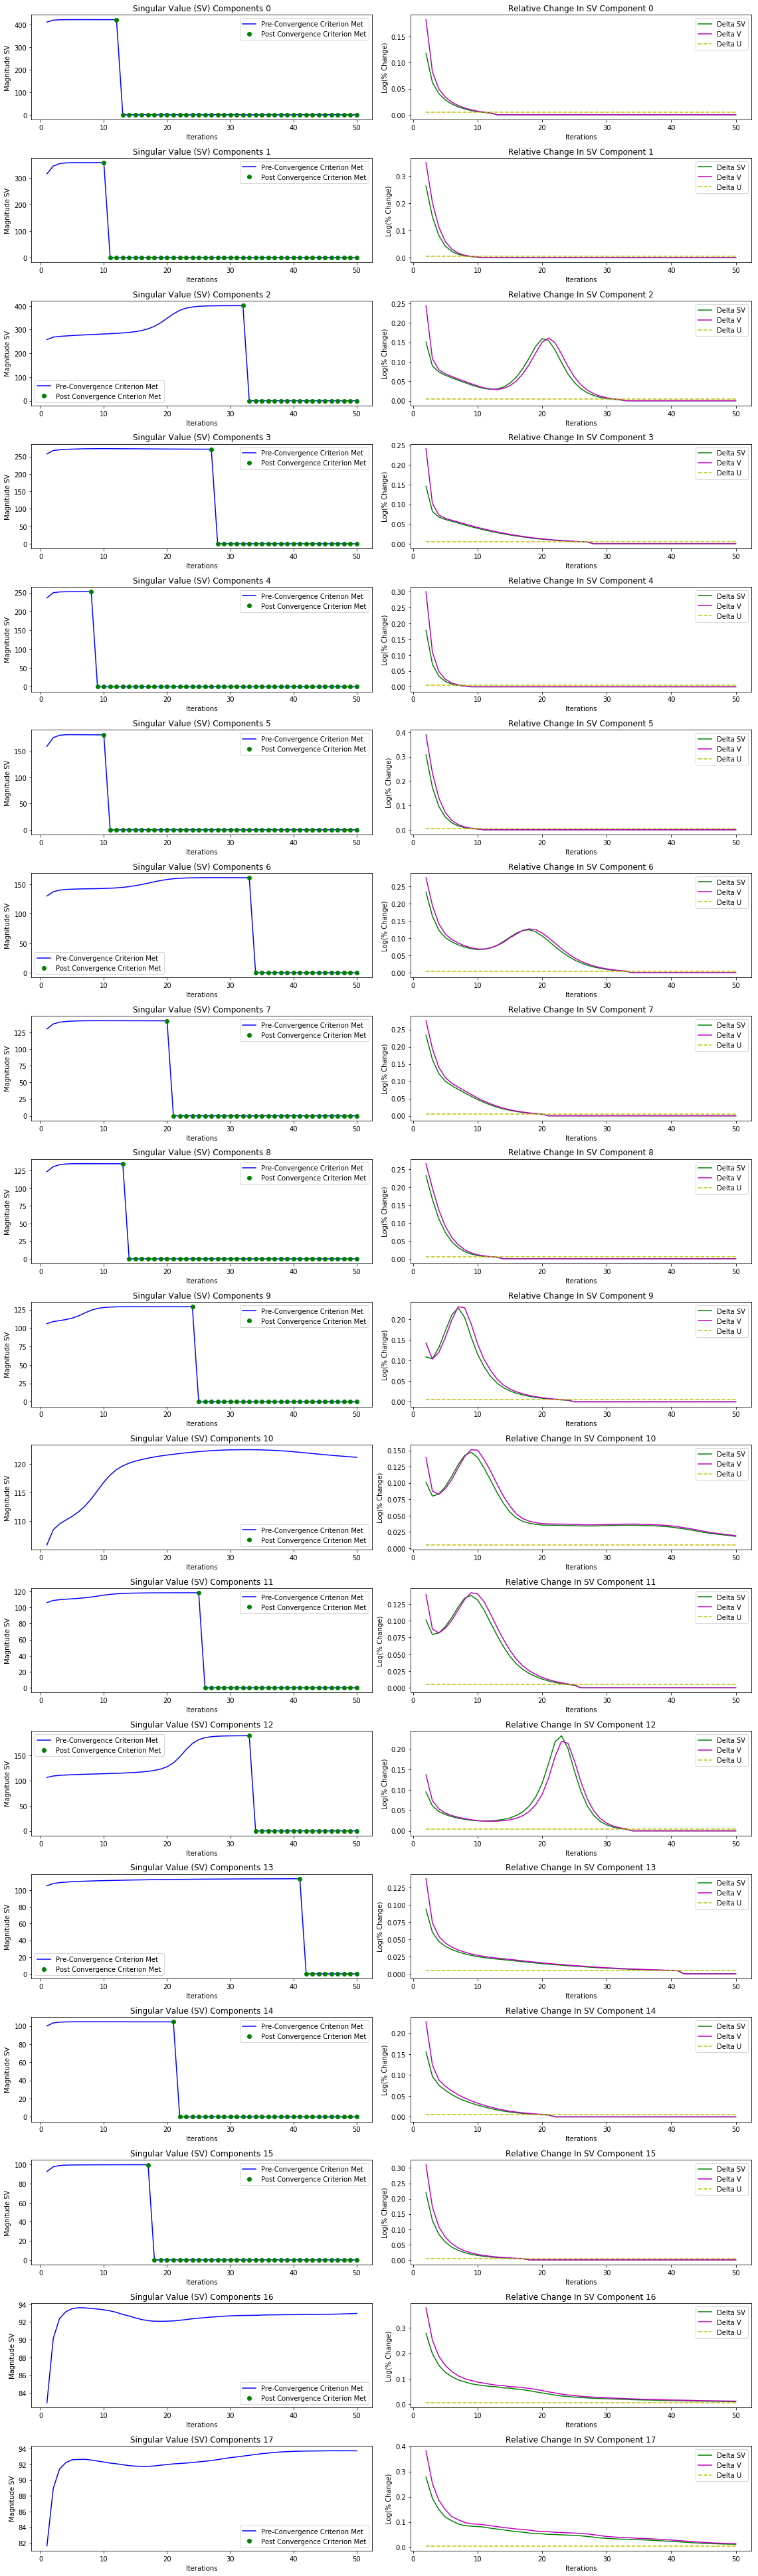

In [15]:
fig, ax = plt.subplots(K+1,2, figsize=(16,3*(K+1)))
for k in range(K+1):
    rel_diff = np.abs(progress[k,:-1,0] - progress[k,1:,0]) / progress[k,:-1,0]
    cdx = np.min(np.append(np.argwhere(np.max(np.vstack([rel_diff,
                              progress[k,1:,1],
                              progress[k,1:,2]]), axis = 0) < tol), [maxiter]))+1
    ax[k,0].plot(np.arange(maxiter)+1, progress[k,:,0], 'b')
    ax[k,0].plot(np.arange(cdx, maxiter)+1, progress[k,cdx:,0], 'go')
    #ax[k,1].plot(np.arange(maxiter-1)+2, rel_diff, 'b')
    ax[k,1].plot(np.arange(maxiter-1)+2, progress[k,1:,1], 'g')
    ax[k,1].plot(np.arange(maxiter-1)+2, progress[k,1:,2], 'm')
    ax[k,1].plot(np.arange(maxiter-1)+2, tol * np.ones(maxiter-1), 'y--')
    ax[k,0].set_title("Singular Value (SV) Components {}".format(k))
    ax[k,1].set_title("Relative Change In SV Component {}".format(k))
    ax[k,0].legend(['Pre-Convergence Criterion Met', 'Post Convergence Criterion Met'])
    ax[k,1].legend(['Delta SV', 'Delta V', 'Delta U', 'Stopping Tolerance'])
    ax[k,0].set_xlabel('Iterations')
    ax[k,1].set_xlabel('Iterations')
    ax[k,0].set_ylabel('Magnitude SV')
    ax[k,1].set_ylabel('Log(% Change)')
plt.tight_layout()
plt.show()

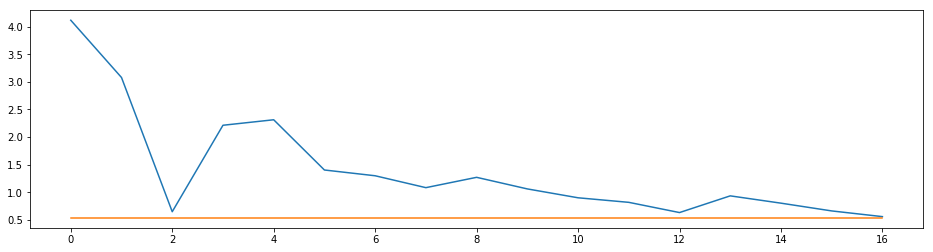

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16,4))

#thresh=.385
thresh= (d1*d2 / ((d1*(d2-1) + d2*(d1-1))))*1.05
metric = np.empty(K)
for k in range(K):
    metric[k] = np.sum(np.abs(U[k,:])) / eval_tv(U[k,:].reshape(Y_block.shape[:2])) 
ax.plot(np.arange(K), metric)
disc_idx=data['disc_idx']
del data
ax.plot(np.arange(K), np.ones(K)*thresh)
plt.show()

In [17]:
temporal_failed = np.argwhere(np.isnan(choose_rank(V, maxlag=10, confidence=.99, mean_th_factor=2)[0,:])).flatten()
keep = np.setdiff1d(np.argwhere(metric > thresh), temporal_failed)
print("components to keep:" + str(keep))

components to keep:[ 0  1  3  4  5  6  7  8  9 10 11 13 14 15 16]


/home/ian/devel/trefide/trefide/utils/greedyPCA.py:250: RuntimeWarning: invalid value encountered in true_divide
  vi =(vi - vi.mean())/vi.std()


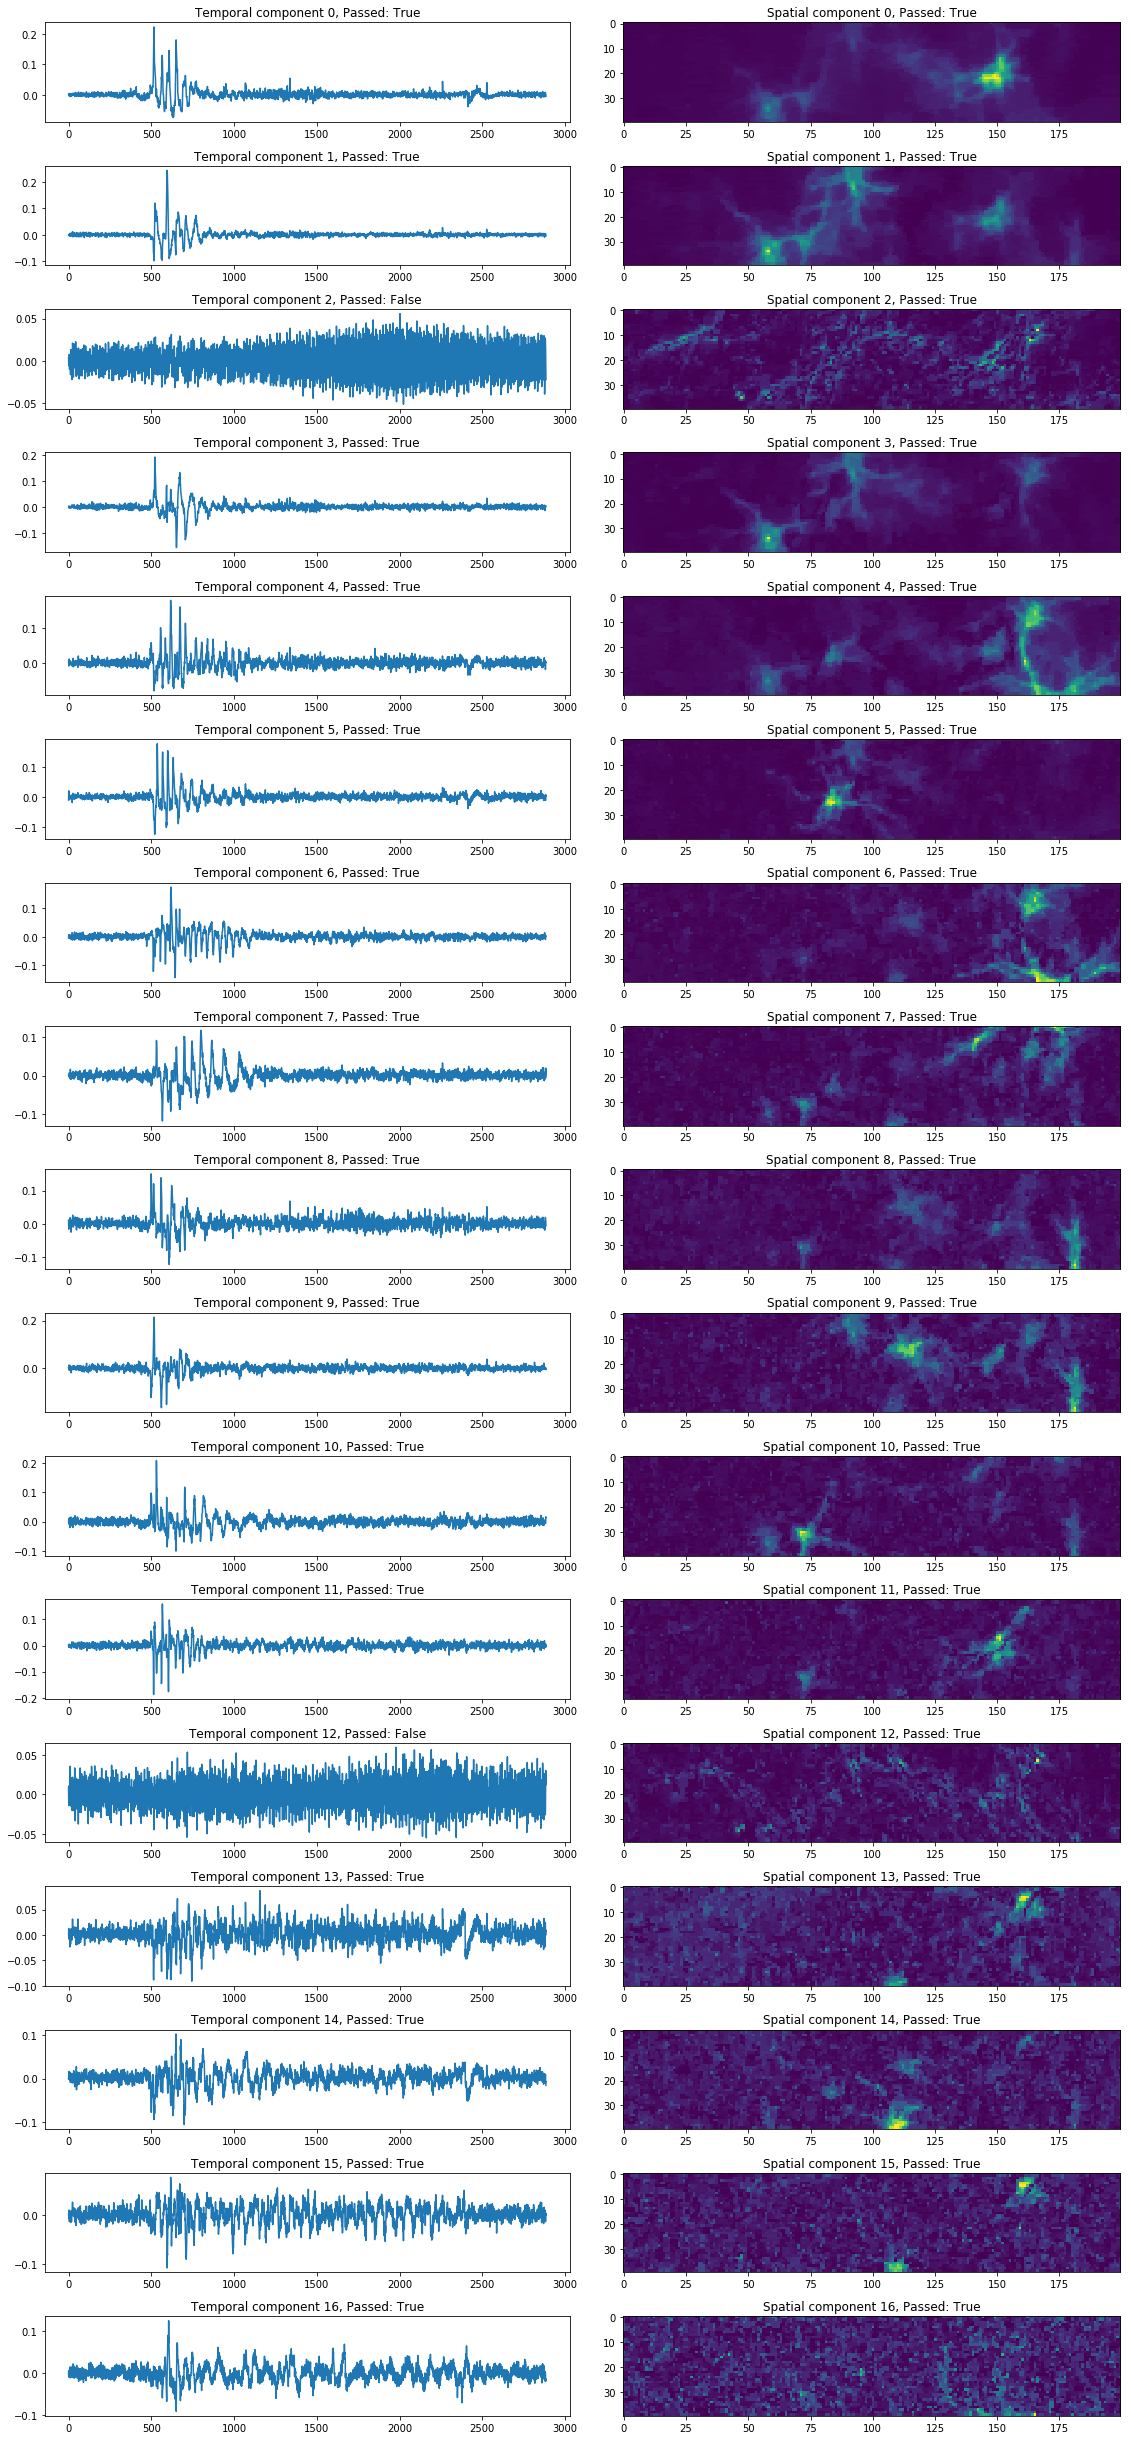

In [18]:
fig, ax = plt.subplots(K, 2, figsize=(16,2*K))
for k in range(K):
    ax[k,0].plot(np.arange(V.shape[-1]), V[k,:])
    ax[k,1].imshow(np.abs(U[k,:].reshape(Y_block.shape[:2])))
    ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    ax[k,1].set_title("Spatial component {}, Passed: {}".format(k, k in np.argwhere(metric > thresh)))
plt.tight_layout()
plt.show()

# Debias and view movie

In [ ]:
X = Y_block.reshape((np.prod(Y_block.shape[:2]), Y_block.shape[-1]), order='C')
V_final = np.linalg.inv(U[keep,:].dot(U[keep,:].T)).dot(U[keep,:].dot(X))
U_final = X.dot(V_final.T.dot(np.linalg.inv(V_final.dot(V_final.T))))
denoised = U_final.dot(V_final).reshape(Y_block.shape, order='C')
raw = Y_block.copy()
residual = raw - denoised
play(np.vstack([raw, denoised, np.abs(raw-denoised)]), magnification=7)

# TV Denoising Analysis

In [ ]:
V_hat = np.array([trend_filter.denoise(v) for v in V])

In [ ]:
def compute_noise(X, v):
    u = X.dot(v)
    return 1 / np.sum(np.power(u, 2))

In [ ]:
k=0
w=.05
orig = Y_block.dot(V[k,:])
orig = orig / np.linalg.norm(orig)
denoised = tv1_2d(orig, w=w)
denoised = denoised / np.linalg.norm(denoised)
mse = np.mean(np.power(orig - denoised, 2))
noise_var = compute_noise(Y_block, V[k,:])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].imshow(np.abs(orig,))
ax[1].imshow(np.abs(denoised))
ax[0].set_title("Raw Spatial Component %d, Noise Estimates: %1.2e"%(k, noise_var))
ax[1].set_title("Denoised SpatialComponent %d, MSE: %1.2e"%(k, mse))
plt.show()

In [ ]:
fig, ax = plt.subplots(K, 2, figsize=(16,K*4))
for k in range(K):
    orig = Y_block.dot(V[k,:])
    orig = orig / np.linalg.norm(orig)
    denoised = tv1_2d(orig, w=w)
    denoised = denoised / np.linalg.norm(denoised)
    mse = np.mean(np.power(orig - denoised, 2))
    noise_var = compute_noise(Y_block, V[k,:])
    ax[k,0].imshow(np.abs(orig))
    ax[k,1].imshow(np.abs(denoised))
    ax[k,0].set_title("Raw Spatial Component %d, Noise Estimates: %1.2e"%(k, noise_var))
    ax[k,1].set_title("Denoised SpatialComponent %d, MSE: %1.2e"%(k, mse))
plt.show()

In [ ]:
from timeit import timeit

In [ ]:
w=.0025
k=7

In [ ]:
noisey = Y_block.dot(V[k,:])
noisey = noisey / np.linalg.norm(noisey)
#noisey = np.tile(noisey,(10, 2))
noisey1 = noisey.copy()
def test_tv():
    tv1_2d(noisey1, w=w, max_iters=1)

In [ ]:
timeit(test_tv, number=10)/10

In [ ]:
#noisey = U[10,:].reshape(Y_block.shape[:2])
noisey2 = noisey.copy()
warm_start = tv1_2d(noisey2, w=w, max_iters=1)
def test_tvws():
    tv1_2dws(noisey, w, warm_start, max_iters=1)

In [ ]:
timeit(test_tvws, number=10)/10

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,16))
ax[0].imshow(np.abs(noisey))
ax[1].imshow(np.abs(warm_start))
#ax[0].set_title("Raw Spatial Component %d, Noise Estimates: %1.2e"%(k, noise_var))
#ax[1].set_title("Denoised SpatialComponent %d, MSE: %1.2e"%(k, mse))
plt.show()

In [ ]:
def update_x(x):
    x = x + 1
    return x
x = np.ones(10)
y = update_x(x[:])

In [ ]:
x = np.ones((3,3))

In [ ]:
y = x.reshape(9)

In [ ]:
y[0]=10
x

# Prepare Data

In [5]:
data = io.loadmat("../data/detrended_sampleMovie.mat")
Y_detr=data['Y_detr']
Y_trend=data['Y_trend']
stim=data['stim']
disc_idx=data['disc_idx']
del data

In [6]:
#Y_block = Y_detr[20:40,720:760].copy()  # 20 x 40
#Y_block = Y_detr[30:50,200:300].copy()  # 20 x 100
#Y_block = Y_detr[40:,600:].copy()       # 40 x 200
#Y_block = Y_detr[:40,600:800].copy()    # 40 x 200
#Y_block = Y_detr[20:60,150:350].copy()  # 40 x 200
#Y_block = Y_detr[:,200:600,].copy()     # 80 x 400
Y_block = Y_detr.copy()
d1, d2, T = Y_block.shape

In [7]:
X = Y_block.reshape((np.prod(Y_block.shape[:2]), Y_block.shape[-1]))
sigma = estimate_noise(X, summarize='mean')
X = (X / sigma[:,None]).reshape(Y_block.shape)